# SI 671/721 (Fall 2021) Data Mining: Methods and Applications

Summary: For this assignment, we sampled ~10 thousand Tweets with two or more food/drink emojis. You
will represent this dataset as a collection of itemsets and practice what we learned in class --
mining and evaluating frequent itemsets, and calculating the similarity of itemsets.

Disclaimer: The data are collected from the real world. As you step into the wild, things might
not always be nice and clean. Although we, the instructing team, have tried our best effort to
filter out Tweets containing poisonous vocabularies and links, it is still possible that you will
encounter offensive contents.

In [32]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import mlxtend
from mlxtend.frequent_patterns import association_rules, apriori
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

## 1.1 Load & transform the Twitter emoji dataset [11 points]

a) [3 points] First, read in the itemsets_data/food_drink_emoji_tweets.txt file and create a pandas DataFrame with the contents. You should find that every line of the data is a Tweet.


In [33]:
tweets_df = pd.read_csv("itemsets_data/food_drink_emoji_tweets.txt", sep="\t", header=None).rename({0: 'Tweet'}, axis=1)
emoji_set = {'🍫', '🍡', '🍏', '🍈', '🍯', '🥠', '🍪', '🌰', '🥯', '🍐', '🌯', '🍧', '🥮', '🥚', '🍎', '🍍', '🍠', '🍨', '🥣', '🍊', '🍘', '🍆', '🥓', '🌽', '🥐', '🌮', '🍬', '🍛', '🥘', '🥔', '🍿', '🍉', '🥞', '🍄', '🎂', '🧀', '🥩', '🍺', '🦀', '🥦', '🥭', '🍒', '🍤', '🦐', '🥝', '🥙', '🍖', '🥜', '🍥', '🍷', '🍾', '🍲', '🧂', '🥪', '🍚', '🥬', '🥑', '🍙', '🍞', '🥃', '🥗', '🍕', '🍔', '🥕', '🧁', '🍋', '🍰', '🥫', '🍗', '🥧', '🥛', '🍮', '🥡', '🍟', '🍅', '🥂', '🍸', '🥥', '🍢', '🍌', '🍝', '🍵', '🍼', '🍦', '🍭', '🍑', '🍹', '🍇', '🥨', '🍱', '🦞', '☕', '🌶', '🍻', '🍳', '🥒', '🍣', '🥟', '🥖', '🍶', '🍜', '🍓', '🦑', '🍩', '🌭'} 

b) [3 points] Using this DataFrame, extract the emojis that appear in each Tweet as an itemset. For this assignment, we are only interested in emojis that are food and drink. As such, you are supplied with the following emoji_set to filter to food and drink emojis:


In [34]:
tweets_df.head(3)

,Tweet
0,RT @CalorieFixess: 🍗🌯🍔🍒 400 Calories https://t...
1,RT @1_F_I_R_S_T: _ 🍈¹〉Grow your account fast! ...
2,RT @LegendDeols: 👉👉👉G€T Ready to dance💃🕺🕺🕺💃💃💃 ...


In [35]:
emojis_per_tweet = {}

for i, row in tweets_df.iterrows():
    temp = set()
    tokens = row['Tweet'].split()
    for token in tokens:
        characters = [char for char in token]
        for char in characters:
            if char in emoji_set:
                temp.add(char)
    # emojis_per_tweet.append(temp)
    emojis_per_tweet[i] = temp

emojis_per_tweet[0]

{'🌯', '🍒', '🍔', '🍗'}

In [36]:
unique_emoji_df = pd.DataFrame(data=emojis_per_tweet.items(), columns=(["Index", "Emojis"])).set_index(keys='Index')
unique_emoji_df

,Emojis
Index,
0,"{🌯, 🍗, 🍒, 🍔}"
1,"{🍍, 🍈, 🍉, 🍇, 🍊, 🍓}"
2,"{🍸, 🥃}"
3,"{🍟, 🍔}"
4,"{🍌, ☕}"
...,...
9953,"{🥃, 🍻}"
9954,"{🍍, 🍏}"
9955,"{🥓, 🍳, ☕}"


In [37]:
len(unique_emoji_df.values)

9958

c) [5 points] Next, as we recommend utilizing the mlxtend package in this assignment to perform frequent itemset mining, you will need to transform the data. The mlxtend package requires that the itemsets be transformed into a matrix before being passed to its APIs, where each row represents an itemset and each column represents an item. Within this matrix, each cell encodes whether an item is in an itemset or not. We recommend the MultiLabelBinarizer function in scikit-learn to implement this transformation. Here is the documentation for the function: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html.

In [38]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
emoji_matrix = mlb.fit_transform(unique_emoji_df['Emojis'])
emoji_inverse = mlb.inverse_transform(emoji_matrix)

print(emoji_matrix)
print(emoji_matrix.shape)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(9958, 105)


## 1.2 Exploratory Data Analysis (EDA) [9 points]

Before we jump into analyzing a dataset, it is always wise to take a look at some summary statistics
first. Some questions to consider:

- [3 points] How many different emojis are used in the dataset?
-  [3 points] How many emojis are used in a Tweet, on average? What does the distribution look like? (hint: plot the distribution!)
-  [3 points] Which emojis are most popular (i.e., used most frequently) in the dataset? Please return the top 5.

In [39]:
import numpy as np

num_rows, num_cols = emoji_matrix.shape
print("Number of unique emojis used in the dataset: {}".format(num_cols))

Number of unique emojis used in the dataset: 105


In [40]:
lengths = []
for item in emoji_matrix:
    lengths.append(item.sum())
    
print("Average number of emojis used per tweet: {}".format(np.mean(lengths)))

Average number of emojis used per tweet: 2.6340630648724646


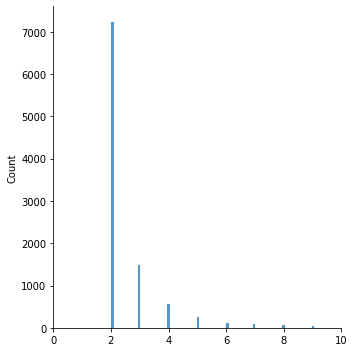

In [41]:
import seaborn as sns
plot = sns.displot(lengths)
plt.xlim(0, 10)
plt.show()

In [42]:
import operator

def sort_dictionary(dictionary):
    return sorted(dictionary.items(), key=operator.itemgetter(1), reverse=True)

In [43]:
emoji_counter = {}

for tup in emoji_inverse:
    for item in tup:
        if item not in emoji_counter.keys():
            emoji_counter[item] = 1
        else:
            emoji_counter[item] += 1
            
top5_emojis = sort_dictionary(emoji_counter)[:5]
print("Top 5 most used emojis: {}".format(top5_emojis))

Top 5 most used emojis: [('🍻', 1809), ('🎂', 1481), ('🍔', 1382), ('🍾', 1078), ('🥂', 1028)]


## 2. The Apriori Algorithm [45 points]

Now, it is time to apply the Apriori algorithm to the emoji dataset. The documentation for the
apriori function can be found at http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/.

a) [10 points] Using apriori, create a function, `emoji_frequent_itemsets`, to find all the frequent
k-itemsets with a minimal support of `min_support` in the emoji dataset. In other words, k and
min_support should be arguments that are passed when the function is called, in addition to the
matrix itself. Your function should return a Pandas DataFrame object with two columns:

- The first one is named `support` and stores the support of the frequent itemsets.
- The second column is named `itemsets` and stores the frequent itemset as a frozenset (the default return type of the apriori API).

Make sure that you are only returning the frequent itemsets that have the specified number of
emojis (k).

In [44]:
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_array = te.fit_transform(emoji_inverse)
k_df = pd.DataFrame(te_array, columns=te.columns_)
k_df

,☕,🌭,🌮,🌯,🌰,🌶,🌽,🍄,🍅,🍆,...,🥭,🥮,🥯,🦀,🦐,🦑,🦞,🧀,🧁,🧂
0,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9953,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9954,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9955,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9956,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [45]:
from mlxtend.frequent_patterns import apriori

def emoji_frequent_itemsets(k, min_support):
    '''
    Takes in k number of emojis
    
    This function returns a DataFrame object with two columns:
     - The first one is named `support` and stores the support of the frequent itemsets.
     - The second column is named `itemsets` and stores the frequent itemset as a frozenset 
         (the default return type of the apriori API).
    '''
    frequent_itemsets = apriori(k, min_support=min_support)
    frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
    return frequent_itemsets

In [46]:
df_ = emoji_frequent_itemsets(k_df, min_support=0.007)
df_[df_.length == 3]

,support,itemsets,length
155,0.007833,"(10, 12, 13)",3
156,0.009239,"(24, 34, 23)",3
157,0.007030,"(48, 46, 47)",3
158,0.011749,"(57, 58, 59)",3
159,0.007532,"(57, 58, 60)",3
160,0.007632,"(57, 58, 61)",3
161,0.007230,"(57, 58, 66)",3
162,0.007230,"(57, 59, 60)",3
163,0.007732,"(57, 59, 61)",3
164,0.007030,"(57, 66, 59)",3


## 2.1 Apriori Algorithm under the Hood [30 points]

In this part of the assignment, we are going to continue our exploration in mining frequent
itemsets. Specifically, we are going to examine a few key steps in the Apriori algorithm.

### 2.1.1 Candidate Generation

A critical step of the Apriori algorithm is candidate generation. That is, candidate
(k+1)-itemsets should be generated from frequent k-itemsets. In the following exercise, we want
you to generate candidate 3-itemsets based on the frequent 2-itemsets.

a) [10 points] You will need to construct a `generate_candidate_3_itemsets` function, which
takes in a list of frequent 2-itemsets and returns a list of the candidate 3-itemsets ("candidate"
means that they may or may not be frequent). Please represent each itemset as a `set` in
Python. Make sure that for each candidate 3-itemset in your returned list, at least one of its
size-2 subset is a frequent 2-itemset, and your list does not contain duplicated itemsets.

We have prepared the frequent 2-itemsets for you, which you can load from the file named
itemsets_data/food_emoji_frequent_2_itemsets.csv. We will evaluate your function by
feeding in the loaded 2-itemsets and examining the return value. Note that the loaded
2-itemsets are different from what you will get with the `emoji_frequent_itemsets` function you
implemented in the previous part, as we have eliminated the drink-related emojis to make the
exercise more trackable.

You will receive full points for this part of the question if (1) every candidate 3-itemset in your
returned list is a superset of at least one frequent 2-itemset, (2) every 3-itemset that has a
frequent size-2 subset is already in your list, and (3) your list does not contain duplicated sets.

In [47]:
itemsets2 = pd.read_csv("itemsets_data/food_emoji_frequent_2_itemsets.csv", header=None)
freq2 = itemsets2.values.tolist()

candidate_2_itemsets = []
for item in freq2:
    candidate_2_itemsets.append(set([char for char in item[0]]))

candidate_2_itemsets[0]

{'🌭', '🍔'}

In [48]:
def generate_candidate_3_itemsets(freq2_list):
    '''
    Takes in a list of frequent 2-itemsets and returns a list of the
    candidate 3-itemsets that for every candidate 3-itemset, at least
    one two of the three objects are a frequent 2-itemset
    '''
    candidate_3_itemsets = []
    
    length = len(freq2_list)    
    k = 3
    
    for i in range(length):
        for j in range(i + 1, length):       
            emoji1 = list(freq2_list[i])[:1]
            emoji2 = list(freq2_list[j])[:1]            
            if emoji1 == emoji2:
                candidate_3_itemsets.append(freq2_list[i] | freq2_list[j])
    
    return candidate_3_itemsets
            
candidate_3_itemsets = generate_candidate_3_itemsets(candidate_2_itemsets)
candidate_3_itemsets[:10]

[{'🌭', '🍔', '🍕'},
 {'🌭', '🍕', '🍟'},
 {'🌭', '🍕', '🍦'},
 {'🌮', '🍔', '🍕'},
 {'🍇', '🍉', '🍊'},
 {'🍇', '🍉', '🍌'},
 {'🍇', '🍉', '🍑'},
 {'🍇', '🍉', '🍒'},
 {'🍇', '🍉', '🎂'},
 {'🍇', '🍊', '🍒'}]

b) [10 points] Note that this pruning procedure won't give us the smallest set of candidates.
Therefore, we can further prune the candidate itemsets by requiring all size-2 subsets of each
candidate 3-itemset to be frequent.

Think about the example you've seen in the lecture. Suppose {🍺,🍼}, {🍺,🍋}, {🍼,🍭}, {🍼,
🍋} are all the frequent 2-itemsets. In the lecture, we said {🍺, 🍼, 🍋}, {🍺, 🍼, 🍭}, {🍼,🍭,
🍋} are candidate 3-itemsets because each 3-itemset is a superset of at least one frequent
2-itemset. However, a larger itemset can never be frequent as long as one of its subset is not
frequent. In this case, {🍺, 🍼, 🍭} can never been frequent because {🍺, 🍭} is not frequent.
Neither can {🍼, 🍭, 🍋}, as the subset {🍭, 🍋} is not frequent. Ideally, we should be able to
exclude the two candidate 3-itemsets {🍺, 🍼, 🍭} and {🍼, 🍭,🍋} even without scanning the
database for counting.

For this exercise, please prune your generated candidate 3-itemsets by requiring all their
subsets to be frequent. You will receive full points for this part if the pruning is done correctly.

In [49]:
def prune_candidate_3_itemsets(list_of_candidate_3_itemsets):
    '''
    Confirms that each candidate 3-itemset is a superset of at least one candidate 2-itemset,
    displaying that a match has been found and dropping supersets if needed
    '''
    print("Number of Itemsets before Pruning: {}".format(len(candidate_3_itemsets)))
    print('='*40)
    
    pruned = []

    for i, itemset3 in enumerate(candidate_3_itemsets):
        itemset3 = list(itemset3)

        try:
            for itemset2 in candidate_2_itemsets:
                itemset2 = list(itemset2)
                if itemset2[0] in itemset3 and itemset2[1] in itemset3:
                    print("{}: Match found for {}: {}-{}".format(i + 1, itemset3, itemset2[0], itemset2[1]))
                    pruned.append(set(itemset3))
                    break

                else:
                    continue
        except:
            print("No subsets found. Dropping superset: {}".format(itemset3))
            
    return pruned
    
pruned = prune_candidate_3_itemsets(candidate_3_itemsets)

Number of Itemsets before Pruning: 155
1: Match found for ['🍕', '🌭', '🍔']: 🌭-🍔
2: Match found for ['🍟', '🍕', '🌭']: 🍕-🌭
3: Match found for ['🍕', '🌭', '🍦']: 🍕-🌭
4: Match found for ['🌮', '🍕', '🍔']: 🌮-🍔
5: Match found for ['🍉', '🍇', '🍊']: 🍉-🍇
6: Match found for ['🍌', '🍉', '🍇']: 🍉-🍇
7: Match found for ['🍉', '🍇', '🍑']: 🍉-🍇
8: Match found for ['🍉', '🍇', '🍒']: 🍉-🍇
9: Match found for ['🍉', '🍇', '🎂']: 🍉-🍇
10: Match found for ['🍇', '🍒', '🍊']: 🍇-🍊
11: Match found for ['🍍', '🍉', '🍇']: 🍉-🍇
12: Match found for ['🍍', '🍇', '🍊']: 🍇-🍊
13: Match found for ['🍍', '🍇', '🍏']: 🍍-🍇
14: Match found for ['🍍', '🍇', '🍓']: 🍍-🍇
15: Match found for ['🍍', '🥝', '🍇']: 🍍-🍇
16: Match found for ['🍎', '🍉', '🍇']: 🍉-🍇
17: Match found for ['🍎', '🍇', '🍊']: 🍇-🍊
18: Match found for ['🍎', '🍇', '🍏']: 🍎-🍇
19: Match found for ['🍎', '🍇', '🍐']: 🍎-🍇
20: Match found for ['🍎', '🍇', '🍒']: 🍎-🍇
21: Match found for ['🍓', '🍉', '🍇']: 🍉-🍇
22: Match found for ['🍓', '🍇', '🍊']: 🍇-🍊
23: Match found for ['🍓', '🍋', '🍇']: 🍓-🍇
24: Match found for ['🍓', '

### 2.1.2 Database Scan

a) [10 points] With the candidate itemsets ready, the final step in one iteration of the Apriori
algorithm is to scan the database (in our case, you can scan the `emoji_matrix` created above
in 1.1c) and count the occurrence of each candidate itemset, divide it by the total number of
records to derive the support, and output candidate itemsets whose support meets a chosen
threshold.

To do so, please construct a new function, `calculate_frequent_itemsets`, where the input
(`candidate_itemsets`) is a list of the candidate 3-itemsets from the previous section. Your
function should return a complete list of frequent 3-itemsets with a minimal support of
`min_support` (i.e., an argument passed to the function). The returned list should not contain
duplicated itemsets. The order of the list does not matter.

In [50]:
# k_df

In [51]:
def calculate_frequent_itemsets(candidate_3_itemsets, min_support):
    '''
    Takes in a list of the candidate 3-itemsets and returns a complete list of frequent 3-itemsets with a
    minimal support of a min_support. 
    '''
    from mlxtend.frequent_patterns import apriori

    #Generate associations
    frequent_itemsets = apriori(k_df, min_support=min_support, use_colnames=True)
    frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
    frequent_3_itemsets = frequent_itemsets[frequent_itemsets['length'] == 3]
    #print(frequent_3_itemsets)
    
    associations = list(zip(
        frequent_3_itemsets['itemsets'].tolist(),
        frequent_3_itemsets['support'].tolist(),
    ))
    
    #Confirm associations are in the frequent 3 itemsets
    relevant_frequent_itemsets = []
    for tup in associations:
        froz_set = tup[0]
        support_score = tup[1]
        
        if froz_set in candidate_3_itemsets:
            print("Match found")
            #relevant_frequent_itemsets.append(froz_set)
            relevant_frequent_itemsets.append((froz_set, support_score))
        else:
            print("No match found")
    
    return relevant_frequent_itemsets
    
calculate_frequent_itemsets(candidate_3_itemsets, min_support=0.007)

Match found
Match found
Match found
No match found
No match found
No match found
No match found
No match found
No match found
No match found
No match found
No match found
No match found
No match found
No match found
No match found


[(frozenset({'🍇', '🍉', '🍊'}), 0.007832898172323759),
 (frozenset({'🍔', '🍕', '🍟'}), 0.009238802972484434),
 (frozenset({'🍫', '🍬', '🍭'}), 0.007029524000803374)]

## 3. Evaluating Frequent Itemsets [25 points]

Even though you may have found all the frequent itemsets, not all of them are “interesting”.
People have developed various measurements of the interestingness of patterns. Most of them
split the itemset into an antecedent item(set) and a consequent item(set), and then measure the
correlation between the antecedent and the consequent. Let's try some of such measurements
implemented by the `mlxtend.frequent_patterns.association_rules` API. For more information
about the API, visit the documentation at http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/.

a) [10 points] First, apply the apriori function to 'emoji_matrix' created in section 1.1c with a
min_support of 0.005 and use_colnames = True. Then, apply the association_rules function to
the result with metric = "lift" and min_threshold = 3 (meaning to only return values where lift is
equal to or greater than 3).

In [52]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

frequent_itemsets = apriori(k_df, min_support=0.005, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=3)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(☕),(🍩),0.058747,0.031332,0.008435,0.143590,4.582906,0.006595,1.131080
1,(🍩),(☕),0.031332,0.058747,0.008435,0.269231,4.582906,0.006595,1.288031
2,(🌭),(🍔),0.019381,0.138783,0.011348,0.585492,4.218764,0.008658,2.077686
3,(🍔),(🌭),0.138783,0.019381,0.011348,0.081766,4.218764,0.008658,1.067939
4,(🍕),(🌭),0.044286,0.019381,0.005021,0.113379,5.849870,0.004163,1.106017
...,...,...,...,...,...,...,...,...,...
511,"(🍸, 🍹)","(🍺, 🍻)",0.023298,0.042478,0.005122,0.219828,5.175043,0.004132,1.227320
512,(🍻),"(🍺, 🍸, 🍹)",0.181663,0.007632,0.005122,0.028192,3.693943,0.003735,1.021157
513,(🍺),"(🍹, 🍸, 🍻)",0.079634,0.007532,0.005122,0.064313,8.539016,0.004522,1.060684
514,(🍸),"(🍺, 🍹, 🍻)",0.052018,0.006527,0.005122,0.098456,15.083398,0.004782,1.101967


b) [10 points] Next, we ask that you implement another interestingness measurement, the (full) mutual information. The measurement is defined as such:

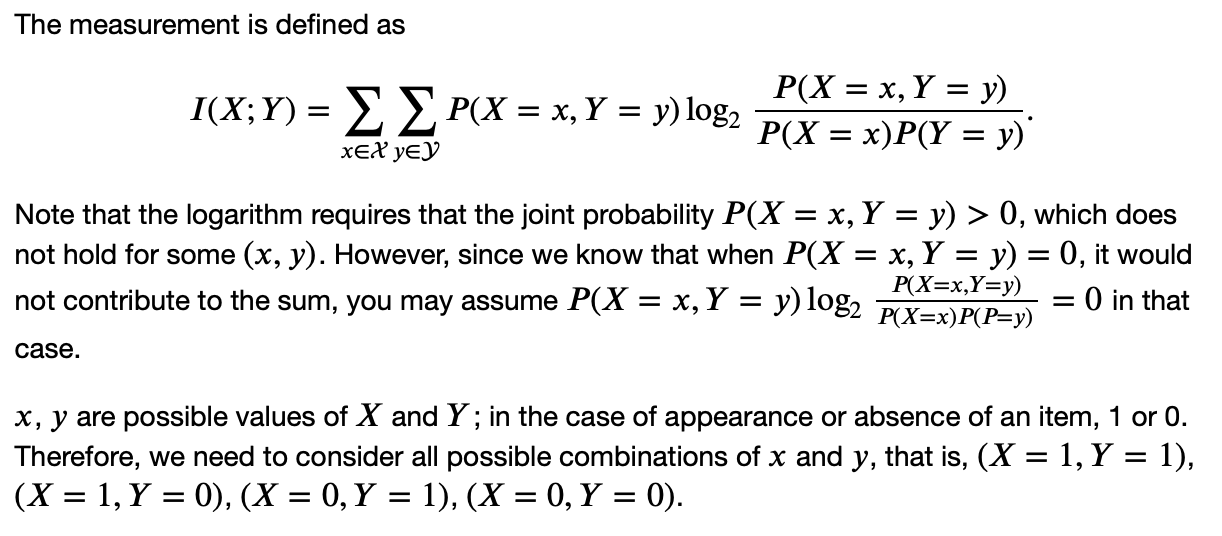

Please construct a function, ‘mi’, that uses the three support values ((1) antecedent support, (2) consequent support and (3) support) to compute the mutual information. All three parameters are in [0, 1], and you can assume the validity of the input. Use 2 as the log base.

In [53]:
def mi(dataframe):
    from math import log2
    '''
    Mutual Information is an interestingness measurement for associations that measures the mutual 
    dependence between two random variables (X, Y)
    
    I(antecedent; consequent) = log2 * (P(antecedent, consequent) / P(antecedent)P(consequent))
    
    '''    
    zipped = list(zip(
        dataframe['antecedent support'].tolist(),
        dataframe['consequent support'].tolist(),
        dataframe['support'].tolist()))
    
    mutual_info_dict = {}
    for i, tup in enumerate(zipped):
        antecedent_support = tup[0]
        consequent_support = tup[1]
        
        support = tup[2]
        support_xneg = (1-antecedent_support) * consequent_support
        support_yneg = antecedent_support * (1-consequent_support)
        support_xyneg = (1-antecedent_support) * (1-consequent_support)
        
        p_normal = support * log2((support) / (antecedent_support * consequent_support))
        p_xneg = support_xneg * log2((support_xneg) / ((1-antecedent_support) * (consequent_support)))
        p_yneg = support_yneg * log2((support_yneg) / ((antecedent_support) * (1-consequent_support)))
        p_xyneg = support_xyneg * log2((support_xyneg) / ((1-antecedent_support) * (1-consequent_support)))
                        
        mi = p_normal + p_xneg + p_yneg + p_xyneg
        mutual_info_dict[i] = mi
    
    return mutual_info_dict
    
mi_dict = mi(rules)

c) [5 points] Then, use this function to add the mutual information value to each row of the DataFrame above (i.e., the results of applying association_rules).

In [54]:
rules['mutual info'] = pd.Series(mi_dict)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,mutual info
0,(☕),(🍩),0.058747,0.031332,0.008435,0.143590,4.582906,0.006595,1.131080,0.018526
1,(🍩),(☕),0.031332,0.058747,0.008435,0.269231,4.582906,0.006595,1.288031,0.018526
2,(🌭),(🍔),0.019381,0.138783,0.011348,0.585492,4.218764,0.008658,2.077686,0.023567
3,(🍔),(🌭),0.138783,0.019381,0.011348,0.081766,4.218764,0.008658,1.067939,0.023567
4,(🍕),(🌭),0.044286,0.019381,0.005021,0.113379,5.849870,0.004163,1.106017,0.012796
...,...,...,...,...,...,...,...,...,...,...
511,"(🍸, 🍹)","(🍺, 🍻)",0.023298,0.042478,0.005122,0.219828,5.175043,0.004132,1.227320,0.012146
512,(🍻),"(🍺, 🍸, 🍹)",0.181663,0.007632,0.005122,0.028192,3.693943,0.003735,1.021157,0.009655
513,(🍺),"(🍹, 🍸, 🍻)",0.079634,0.007532,0.005122,0.064313,8.539016,0.004522,1.060684,0.015846
514,(🍸),"(🍺, 🍹, 🍻)",0.052018,0.006527,0.005122,0.098456,15.083398,0.004782,1.101967,0.020050


## 4.1 Jaccard Similarity

Jaccard similarity is a simple but powerful measurement of itemset similarity, defined as follows:

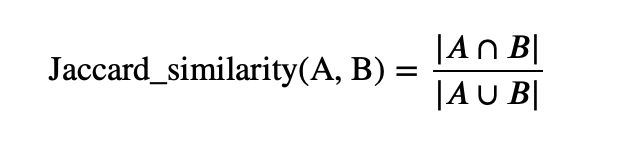

a) [5 points] Complete a function, ‘jaccard_similarity’, to calculate the Jaccard similarity between two sets. You may assume that at least one of the sets is not empty.

In [55]:
def jaccard_similarity(set1, set2):
    '''
    Takes two sets and calculates a jaccard similarity score
    given that at least one set is not empty
    '''
    intersection = len(list(set1.intersection(set2)))
    union = (len(set1) + len(set2)) - intersection
    return intersection / union

In [56]:
#Test
a = {'🍔', '🍗', '🌮'}
b = {'🍔', '🍟', '🌮'}

jaccard_similarity(a, b)

0.5

b) [5 points] With this Jaccard similarity function, please calculate the Jaccard similarity between any given Tweet with all other Tweets and find the Tweets that are most similar (i.e., have the highest jaccard similarity values) in terms of the set of food/drink emojis used. How would you interpret the results?

In [57]:
unique_emoji_df.head(5)

,Emojis
Index,
0,"{🌯, 🍗, 🍒, 🍔}"
1,"{🍍, 🍈, 🍉, 🍇, 🍊, 🍓}"
2,"{🍸, 🥃}"
3,"{🍟, 🍔}"
4,"{🍌, ☕}"


In [58]:
results = {}
first_three_rows = unique_emoji_df.iloc[:3]
counter = 1
for row1 in first_three_rows.iterrows():
    set1 = row1[1]['Emojis']
    scores = []
    for row2 in unique_emoji_df.iterrows():
        set2 = row2[1]['Emojis']
        jaccard_score = jaccard_similarity(set1, set2)
        
        if jaccard_score == 0: #Way of speeding up formula: skip jaccard scores of 0
            pass
        else:
            scores.append((set2, jaccard_score))
    results[counter] = (set1, scores)
    counter += 1

In [59]:
def Sort_Tuple(tup): 
    lst = len(tup) 
    for i in range(0, lst): 
        for j in range(0, lst-i-1): 
            if (tup[j][1] > tup[j + 1][1]): 
                temp = tup[j] 
                tup[j]= tup[j + 1] 
                tup[j + 1]= temp 
    return tup

def removeDuplicates(lst):
    return [[a, b] for i, [a, b] in enumerate(lst) if not any(c == b for _, c in lst[:i])]

In [ ]:
tweet1 = results[1][1]
print("Tweet 1 Set: {}".format(results[1][0]))
tweet2 = results[2][1]
print("Tweet 2 Set: {}".format(results[2][0]))
tweet3 = results[3][1]
print("Tweet 3 Set: {}".format(results[3][0]))
print("")

for i, tweet in enumerate([tweet1, tweet2, tweet3]):
    tweet_sorted = Sort_Tuple(tweet)[::-1]
    no_duplicates = removeDuplicates(tweet_sorted)
    top3_tuples = no_duplicates[1:4] #skip 0 as that is just an exact match of itself
    
    print("Tweet #{} top Jaccard Similarity scores".format(i + 1))
    # print("{}".format(emojis))
    
    for i, score in enumerate(top3_tuples):
        print("{}: (Score: {}), emojis: {}".format(i, round(score[1], 3), score[0]))
    print("")

Tweet 1 Set: {'🌯', '🍗', '🍒', '🍔'}
Tweet 2 Set: {'🍍', '🍈', '🍉', '🍇', '🍊', '🍓'}
Tweet 3 Set: {'🍸', '🥃'}



The results above appear to be an accurate implementations of the Jaccard Similarity function. The first three tweets in the Tweet dataframe were explored above (it would be too time consuming to comb through all 10K tweets) and the top 3 emoji sets in a given tweet and their Jaccard Similarity score were listed in order by score. The first tweet referenced {'🌯', '🍔', '🍒', '🍗'} appears to have a 0.75 Jaccard Similarity score with {'🌯', '🍔', '🍗'}, a set of emojis missing just one of the emojis from the original reference tweet. The results following also demonstrate a trend that the presence of emojis from the reference tweet in the compared tweets indicating commonality is crucial for a high Jaccard Similarity score. 